## Susceptible-Infected-Recovered-Deceased model

The susceptible population $NS(t)$ decreases through contact with infected, at a rate given by $\lambda$:

\begin{equation}
\frac{d(NS)}{dt} = -\lambda S N I
\end{equation}

$\lambda$ is the "daily contact rate", which means that if everyone were suceptible and uninfected, one infected person would infect $\lambda$ people per day. So the average number of susceptibles infected by an infectious person per day is $\lambda S$.

The infected population $NI(t)$ increases through contact with infected (at a rate set by $\lambda$), decreases through recovery, at a rate $\gamma$, and also decreases through death, at a rate $\mu$.

\begin{equation}
\frac{d(NI)}{dt} = \lambda S N I - \gamma N I - \mu N I
\end{equation}

What does $\gamma$ mean? Individuals recover and are removed from the infective class at a rate proportional to the number of infectives with proportionality constant $\gamma$, called the daily recovery removal rate.

The latent period is zero (it is defined as the period between the time of exposure and the time when infectiousness begins).
Thus the proportion of individuals exposed (and immediately infective) at time $t_0$ who are still infective at time $t_0 + t$ is $\exp(-\gamma t)$, and the average period of infectivity is $P=1/\gamma$.

The recovered population $NR(t)$ increases when members of the infected population recover. We assume (for now) that all recovered people are henceforth immune to being infected a second time.

\begin{equation}
\frac{d(NR)}{dt} = \gamma I N
\end{equation}

The deceased population $ND(t)$ increases through death at a rate $\mu$
\begin{equation}
\frac{d(ND)}{dt} = \mu I N
\end{equation}

Members of the infected population leave $I(t)$ either by recovering (at a rate $\gamma$), or dying (at a rate $\mu$).
Therefore the chance of an infected individual dying (the average lethality) is $L=\mu/\gamma$.

The "basic reproductive number" (also known as "contact number") $R_0$ is defined as $R_0=\lambda / (\gamma + \mu)$. This comes from the fact that accounting for the deaths of infected gives a death-adjusted average period of infectivity of $1/(\gamma + \mu)$, and multiplying that time period by the daily contact rate $\gamma$.

The fact that the membership of all groups together must add up to the total population is expressed as
\begin{equation}
NS + NI + NR + ND = N
\end{equation}
We've also assumed that the total population is constant (including deceased), and that the epidemic occurs in a timeframe much shorter than that over which natural births and deaths significantly affect any of the populations.

Now we can simplify our equations by dividing through by $N$

\begin{align}
\frac{dS}{dt} & = -\lambda S I \\
\frac{dI}{dt} & = \lambda S I - \gamma I - \mu I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dD}{dt} & = \mu I 
\end{align}

and we also have the boundary condition
\begin{equation}
S + I + R + D = 1
\end{equation}

## Modelling the coronavirus

Okay let's try and model the coronavirus by solving these equations.

Our equations are a system of linear ordinary differential equations, and we will start from a set of known initial values, so we're going to need `scipy`'s [`integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function. 

(In fact, scipy has an example we can follow that is extremely similar, ["Modelling a zombie apocalypse"](https://scipy-cookbook.readthedocs.io/items/Zombie_Apocalypse_ODEINT.html).)

### Population parameters

In [1]:
# Reported UK coronavirus numbers on 15th March 2020
N = 66440000    # population
cases = 1391    # total reported cases including resolved
deaths = 35
recovered = 20

tf = 300        # number of days to run simulation for

### Virus parameters

In [2]:
R_0 = 2.6  # Basic Reproductive Rate [people]
L = 0.035  # Case Fatality Rate [fraction]
P = 14     # Average infectious period [days] (should really be split up by case severity)

In [19]:
from scipy.integrate import solve_ivp
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np

Let's write out the equations for the derivatives we need to calculate.

In [4]:
def dSdt(S, I, lamb):
    return -lamb*S*I

def dIdt(S, I, lamb, gamma, mu):
    return lamb*S*I - gamma*I - mu*I

def dRdt(I, gamma):
    return gamma*I

def dDdt(I, mu):
    return mu*I

def SIRD_eqns(t, y, lamb, gamma, mu):
    S, I, R, D = y
    return [dSdt(S, I, lamb),
            dIdt(S, I, lamb, gamma, mu), 
            dRdt(I, gamma),
            dDdt(I, mu)]

and now solve them

In [20]:
def solve(eqns, N, cases, recovered, deaths,
          P, L, R_0):
    
    # Compute initial values
    R0 = int(recovered)/int(N)
    D0 = deaths/N
    S0 = (N - cases)/N
    I0 = 1 - S0 - R0 - D0
    initial = [S0, I0, R0, D0]

    # Compute coefficients
    gamma = 1 / P
    mu = gamma * L
    lamb = R_0 * (gamma + mu)

    # Solve
    t_span = (0, tf)
    soln = solve_ivp(SIRD_eqns, t_span, initial, args=(lamb, gamma, mu),
                     t_eval=np.linspace(0, tf, tf*2))
    return soln

In [21]:
def plot_viral_spread(N, initial_cases, initial_recovered, initial_deaths,
                      P, L, R_0):

    soln = solve(SIRD_eqns, N, 
                 initial_cases, initial_recovered, initial_deaths,
                 P, L, R_0)

    S, I, R, D = soln.y
    t = soln.t

    print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
    print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
    print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
    print(f"At the virus' maximum {I.max()*100:.1f}% people were simultaneously infected, or {R.max()*N:.0f} people.")
    print(f"After {t[-1]:.0f} days the virus was present in less than {I[-1]*N:.0f} individuals.")
    
    fig, ax = plt.subplots()
    ax.set_title("Covid-19 spread")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("People")
    ax.plot(t, S*N, label="Susceptible", linewidth=2, color='blue')
    ax.plot(t, I*N, label="Infected", linewidth=2, color='orange')
    ax.plot(t, R*N, label="Recovered", linewidth=2, color='green')
    ax.plot(t, D*N, label="Deceased", linewidth=2, color='red')
    ax.legend()
    
    plt.show()

For a population of 66440000 people, after 300 days there were:
3.1% total deaths, or 2030916 people.
87.3% total recovered, or 58025185 people.
At the virus' maximum 24.8% people were simultaneously infected, or 58025185 people.
After 300 days the virus was present in less than 475 individuals.


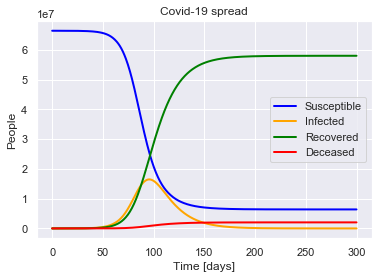

In [22]:
plot_viral_spread(N, cases, recovered, deaths, P, L, R_0)

In [23]:
from ipywidgets import interact, fixed
from ipywidgets import IntSlider, IntRangeSlider, FloatSlider, Dropdown

In [24]:
P_slider = IntSlider(min=1, max=30, step=1, value=14)
R_0_slider = FloatSlider(min=0.1, max=15, step=0.1, value=2.6)
L_slider = FloatSlider(min=0.001, max=0.05, step=0.001, value=0.035)

In [29]:
interact(plot_viral_spread, 
         N=fixed(N), initial_cases=fixed(cases), 
         initial_recovered=fixed(recovered), initial_deaths=fixed(deaths), 
         P=P_slider, L=L_slider, R_0=R_0_slider,
         continuous_update=False)

interactive(children=(IntSlider(value=14, description='P', max=30, min=1), FloatSlider(value=0.035, descriptio…

<function __main__.plot_viral_spread(N, initial_cases, initial_recovered, initial_deaths, P, L, R_0)>

## Social distancing

How can social distancing help? 

Social distancing effectively reduces $R_0$. If $R_0=0$ (everyone lives alone in a box) then there would be no new infections, and the disease would die out once all the infected had either recovered or died.

If $R_0 < 1$ then new people will still be infected, but not fast enough to sustain the virus, and the contagion will decay away.

But if $R_0>1$, even if only a bit greater, than the virus will still grow exponentially.
It will grow more slowly, but will still pick up pace, becoming faster and faster.

So why do social distancing? If we can decrease $R_0$, in other words we can `#flattenthecurve`.

## Lockdown policies

But just changing $R_0$ overall isn't realistic, it assumes that as soon as the virus was discovered, everyone who is near it practices social distancing immediately and indefinitely.
What is more realistic is that once it's realised that the disease could cause an epidemic, governments encourage (or enforce) varying degrees of social distancing through policies like quarantining, lockdowns, banning large events, and working from home.

How can we parameterise a change in the effectiveness of social distancing through policies like these?
Let's try adjusting $R_0$ using a "quarantine parameter" $Q$.
When $Q=0$ then the disease spreads freely, but when $Q=1$ we are on total lockdown and the disease can't spread at all.

We can represent this by changing our equations for the fraction of susceptible and infected people to

\begin{align}
\frac{dS}{dt} & = -\lambda(1 - Q) S I \\
\frac{dI}{dt} & = \lambda(1 - Q) S I - \gamma I - \mu I
\end{align}

If we make $Q$ a function of time $Q=Q(t)$, then we can simulate the effect of varying the level of social distancing in response to the virus.

We can model a sudden permanent lockdown by setting $Q=Q_0H(t-t_Q)$, where $H$ is the heaviside step function
\begin{equation} 
H(t) = 
  \begin{cases} 
    0 & t\lt t_Q \\
    1 & t\geq t_Q 
  \end{cases}
\end{equation}
This just means there are zero social distancing measures in place before day $t_Q$, and then immediate distancing measures of effectiveness $Q$ are enforced permanently from day $t_Q$.

To model this, we need $\frac{dS}{dt} = \frac{dS}{dt}(Q(t-t_Q))$

In [78]:
def dSdt(S, I, lamb, Q):
    return -lamb*(1-Q)*S*I
                 
def dIdt(S, I, lamb, gamma, mu, Q):
    return lamb*(1-Q)*S*I - gamma*I - mu*I

def Q(t, Q0, t_Q):
    if t > t_Q:
        return Q0
    else:
        return 0

def SIRDQ_eqns(t, y, lamb, gamma, mu, Q0, t_Q):
    S, I, R, D = y
    
    q = Q(t, Q0, t_Q)
    
    return [dSdt(S, I, lamb, q),
            dIdt(S, I, lamb, gamma, mu, q), 
            dRdt(I, gamma),
            dDdt(I, mu)]

In [79]:
# Just change a "setup" function instead?

def solve(eqns, N, cases, recovered, deaths,
          P, L, R_0, Q0, t_Q):
    
    # Compute initial values
    R0 = int(recovered)/int(N)
    D0 = deaths/N
    S0 = (N - cases)/N
    I0 = 1 - S0 - R0 - D0
    initial = [S0, I0, R0, D0]

    # Compute coefficients
    gamma = 1 / P
    mu = gamma * L
    lamb = R_0 * (gamma + mu)

    # Solve
    t_span = (0, tf)
    soln = solve_ivp(eqns, t_span, initial, args=(lamb, gamma, mu, Q0, t_Q),
                     t_eval=np.linspace(0, tf, tf*2))
    return soln

In [88]:
def plot_viral_spread_with_distancing(N, initial_cases, initial_recovered, initial_deaths,
                                      P, L, R_0, Q0, t_Q):

    soln = solve(SIRDQ_eqns, N, 
                 initial_cases, initial_recovered, initial_deaths,
                 P, L, R_0, Q0, t_Q)

    S, I, R, D = soln.y
    t = soln.t

    print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
    print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
    print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
    print(f"At the virus' maximum {I.max()*100:.1f}% people were simultaneously infected, or {R.max()*N:.0f} people.")
    print(f"After {t[-1]:.0f} days the virus was present in less than {I[-1]*N:.0f} individuals.")
    print(f"Social distancing of effectiveness {Q0} began on day {t_Q}.")
    
    fig, ax = plt.subplots()
    ax.set_title("Covid-19 spread")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("People")
    ax.plot(t, S*N, label="Susceptible", linewidth=2, color='blue')
    ax.plot(t, I*N, label="Infected", linewidth=2, color='orange')
    ax.plot(t, R*N, label="Recovered", linewidth=2, color='green')
    ax.plot(t, D*N, label="Deceased", linewidth=2, color='red')
    ax.legend()
    
    # Mark intervention point
    ax.axvline(x=t_Q, linewidth=2, color='black')
    ax.text(x=t_Q+5, y=N*0.85, s="Social \ndistancing \nbegins")
    
    plt.show()

For a population of 66440000 people, after 300 days there were:
1.9% total deaths, or 1251313 people.
53.8% total recovered, or 35750811 people.
At the virus' maximum 9.9% people were simultaneously infected, or 35750811 people.
After 300 days the virus was present in less than 22521 individuals.
Social distancing of effectiveness 0.5 began on day 75.


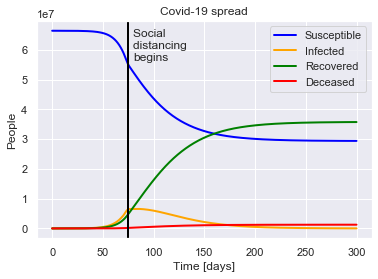

In [89]:
plot_viral_spread_with_distancing(N, cases, recovered, deaths, P, L, R_0, Q0=0.5, t_Q=75)

These policies might be implemented only once the virus has been spreading for a while.

In [75]:
Q0_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5)
t_Q_slider = IntSlider(min=0, max=tf*0.5, value=75)

In [76]:
interact(plot_viral_spread_with_distancing, 
         N=fixed(N), initial_cases=fixed(cases), 
         initial_recovered=fixed(recovered), initial_deaths=fixed(deaths), 
         P=P_slider, L=L_slider, R_0=R_0_slider, Q0=Q0_slider, t_Q=t_Q_slider,
         continuous_update=False)

interactive(children=(IntSlider(value=14, description='P', max=30, min=1), FloatSlider(value=0.035, descriptio…

<function __main__.plot_viral_spread_with_distancing(N, initial_cases, initial_recovered, initial_deaths, P, L, R_0, Q0, t_Q)>

Or perhaps these policies will only be ramped up when there are lots of people infected. 

### Second wave?

The deadliest part of the 1918 Spanish Flu epidemic was the second wave that remerged in the winter.

Although it's yet not clear if Covid-19 is significantly affected by temperature, there are also fears that slacking off on isolation measures will trigger a second wave.

Can we model this?

Let's alter our $Q(t)$ to also stop isolation measures at a certain point in time. Let's call this time $t_{UQ}$ (for "Un-Quarantine"). Then $Q$ becomes

\begin{equation} 
H(t) = 
  \begin{cases} 
    0 & t\lt t_Q \\
    1 & t_Q \leq t \lt t_{UQ} \\
    0 & t\geq t_{UQ}
  \end{cases}
\end{equation}

In [99]:
def Q(t, Q0, t_Q, t_UQ):
    if t_Q < t <= t_UQ:
        return Q0
    else:
        return 0

def SIRDUQ_eqns(t, y, lamb, gamma, mu, Q0, t_Q, t_UQ):
    S, I, R, D = y
    
    q = Q(t, Q0, t_Q, t_UQ)
    
    return [dSdt(S, I, lamb, q),
            dIdt(S, I, lamb, gamma, mu, q), 
            dRdt(I, gamma),
            dDdt(I, mu)]

In [95]:
# Just change a "setup" function instead?

def solve(eqns, N, cases, recovered, deaths,
          P, L, R_0, Q0, t_Q, t_UQ):
    
    # Compute initial values
    R0 = int(recovered)/int(N)
    D0 = deaths/N
    S0 = (N - cases)/N
    I0 = 1 - S0 - R0 - D0
    initial = [S0, I0, R0, D0]

    # Compute coefficients
    gamma = 1 / P
    mu = gamma * L
    lamb = R_0 * (gamma + mu)

    # Solve
    t_span = (0, tf)
    soln = solve_ivp(eqns, t_span, initial, args=(lamb, gamma, mu, Q0, t_Q, t_UQ),
                     t_eval=np.linspace(0, tf, tf*2))
    return soln

In [121]:
def plot_viral_spread_with_distancing(N, initial_cases, initial_recovered, initial_deaths,
                                      P, L, R_0, Q0, t_Q, t_UQ):

    soln = solve(SIRDUQ_eqns, N, 
                 initial_cases, initial_recovered, initial_deaths,
                 P, L, R_0, Q0, t_Q, t_UQ)

    S, I, R, D = soln.y
    t = soln.t

    print(f"For a population of {N} people, after {t[-1]:.0f} days there were:")
    print(f"{D[-1]*100:.1f}% total deaths, or {D[-1]*N:.0f} people.")
    print(f"{R[-1]*100:.1f}% total recovered, or {R[-1]*N:.0f} people.")
    print(f"At the virus' maximum {I.max()*100:.1f}% people were simultaneously infected, or {R.max()*N:.0f} people.")
    print(f"After {t[-1]:.0f} days the virus was present in less than {I[-1]*N:.0f} individuals.")
    
    
    fig, ax = plt.subplots()
    ax.set_title("Covid-19 spread")
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("People")
    ax.plot(t, S*N, label="Susceptible", linewidth=2, color='blue')
    ax.plot(t, I*N, label="Infected", linewidth=2, color='orange')
    ax.plot(t, R*N, label="Recovered", linewidth=2, color='green')
    ax.plot(t, D*N, label="Deceased", linewidth=2, color='red')
    ax.legend()
    
    # Mark point where isolation begins
    print(f"Social distancing of effectiveness {Q0} began on day {t_Q}.")
    ax.axvline(x=t_Q, linewidth=2, color='black')
    ax.text(x=t_Q+5, y=N*0.85, s="Social \ndistancing \nbegins")
    
    # Mark point where isolation ends
    print(f"Social distancing ended on day {t_UQ}.")
    ax.axvline(x=t_UQ, linewidth=2, color='black')
    ax.text(x=t_UQ+5, y=N*0.85, s="Social \ndistancing \nends")
    
    plt.show()

For a population of 66440000 people, after 300 days there were:
2.8% total deaths, or 1849514 people.
79.5% total recovered, or 52842284 people.
At the virus' maximum 11.4% people were simultaneously infected, or 52842284 people.
After 300 days the virus was present in less than 665851 individuals.
Social distancing of effectiveness 0.8 began on day 75.
Social distancing ended on day 150.


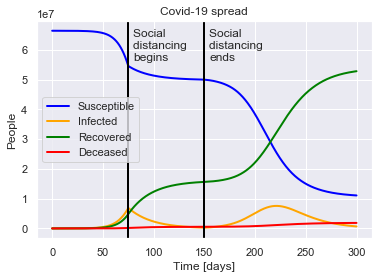

In [122]:
plot_viral_spread_with_distancing(N, cases, recovered, deaths, P, L, R_0=2.6, Q0=0.8, t_Q=75, t_UQ=150)

## Herd immunity